In [1]:
import os
from dotenv import load_dotenv
load_dotenv(os.path.join("..", ".env"), override=True)

True

In [3]:
"""State management for deep agents with TODO tracking and virtual file systems.

This module defines the extended agent state structure that supports:
- Task planning and progress tracking through TODO lists
- Context offloading through a virtual file system stored in state
- Efficient state merging with reducer functions
"""

from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState


class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}  # “두 딕셔너리를 합치되, 같은 키는 right 값을 사용” 이라는 뜻입니다.


class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

In [4]:
WRITE_TODOS_DESCRIPTION = """Create and manage structured task lists for tracking progress through complex workflows.

## When to Use
- Multi-step or non-trivial tasks requiring coordination
- When user provides multiple tasks or explicitly requests todo list  
- Avoid for single, trivial actions unless directed otherwise

## Structure
- Maintain one list containing multiple todo objects (content, status, id)
- Use clear, actionable content descriptions
- Status must be: pending, in_progress, or completed

## Best Practices  
- Only one in_progress task at a time
- Mark completed immediately when task is fully done
- Always send the full updated list when making changes
- Prune irrelevant items to keep list focused

## Progress Updates
- Call TodoWrite again to change task status or edit content
- Reflect real-time progress; don't batch completions  
- If blocked, keep in_progress and add new task describing blocker

## Parameters
- todos: List of TODO items with content and status fields

## Returns
Updates agent state with new todo list."""

In [5]:
"""TODO management tools for task planning and progress tracking.

This module provides tools for creating and managing structured task lists
that enable agents to plan complex workflows and track progress through
multi-step operations.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

@tool(description=WRITE_TODOS_DESCRIPTION,parse_docstring=True)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )


@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Formatted string representation of the current TODO list
    """
    todos = state.get("todos", [])
    if not todos:
        return "No todos currently in the list."

    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"

    return result.strip()

In [6]:
TODO_USAGE_INSTRUCTIONS = """Based upon the user's request:
1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.
2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan. 
3. Reflect on what you've done and the TODO.
4. Mark you task as completed, and proceed to the next TODO.
5. Continue this process until you have completed all TODOs.

IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY user request.
IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have to keep track of.
"""

In [7]:
import json

from rich.console import Console
from rich.panel import Panel
from rich.text import Text

console = Console()


def format_message_content(message):
    """Convert message content to displayable string."""
    parts = []
    tool_calls_processed = False

    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get("type") == "text":
                parts.append(item["text"])
            elif item.get("type") == "tool_use":
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2, ensure_ascii=False)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))

    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if (
        not tool_calls_processed
        and hasattr(message, "tool_calls")
        and message.tool_calls
    ):
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2, ensure_ascii=False)}")
            parts.append(f"   ID: {tool_call['id']}")

    return "\n".join(parts)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting."""
    for m in messages:
        msg_type = m.__class__.__name__.replace("Message", "")
        content = format_message_content(m)

        if msg_type == "Human":
            console.print(Panel(content, title="🧑 Human", border_style="blue"))
        elif msg_type == "Ai":
            console.print(Panel(content, title="🤖 Assistant", border_style="green"))
        elif msg_type == "Tool":
            console.print(Panel(content, title="🔧 Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"📝 {msg_type}", border_style="white"))


def format_message(messages):
    """Alias for format_messages for backward compatibility."""
    return format_messages(messages)


def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """Display a prompt with rich formatting and XML tag highlighting.

    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r"<[^>]+>", style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(
        r"##[^#\n]+", style="bold magenta"
    )  # Highlight headers
    formatted_text.highlight_regex(
        r"###[^#\n]+", style="bold cyan"
    )  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(
        Panel(
            formatted_text,
            title=f"[bold green]{title}[/bold green]",
            border_style=border_style,
            padding=(1, 2),
        )
    )

# more expressive runner
async def stream_agent(agent, query, config=None):
    async for graph_name, stream_mode, event in agent.astream(
        query,
        stream_mode=["updates", "values"], 
        subgraphs=True,
        config=config
    ):
        if stream_mode == "updates":
            print(f'Graph: {graph_name if len(graph_name) > 0 else "root"}')
            
            node, result = list(event.items())[0]
            print(f'Node: {node}')
            
            for key in result.keys():
                if "messages" in key:
                    # print(f"Messages key: {key}")
                    format_messages(result[key])
                    break
        elif stream_mode == "values":
            current_state = event

    return current_state

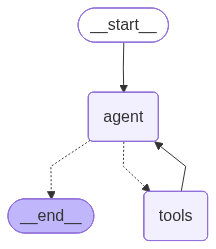

In [20]:
from IPython.display import Image, display
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Create agent using create_react_agent directly
model = ChatGroq(temperature=0, model_name= "openai/gpt-oss-120b")
tools = [write_todos, web_search, read_todos]
# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SIMPLE_RESEARCH_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [21]:
# Example usage
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me a short summary of the Model Context Protocol (MCP).",
            }
        ],
        "todos": [],
    }
)
result

{'messages': [HumanMessage(content='Give me a short summary of the Model Context Protocol (MCP).', additional_kwargs={}, response_metadata={}, id='466086b1-b160-4f99-a213-1b09d4afa28d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fc_f6fe9b99-227e-4169-ba2d-7503b9c3281a', 'function': {'arguments': '{"todos":[{"content":"Research and summarize Model Context Protocol (MCP)","status":"in_progress"}]}', 'name': 'write_todos'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 128, 'prompt_tokens': 738, 'total_tokens': 866, 'completion_time': 0.258671902, 'prompt_time': 0.030393266, 'queue_time': 0.20991974, 'total_time': 0.289065168}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e96a2775-2a48-4571-8e5b-5d7cbdaa45e3-0', tool_calls=[{'name': 'write_todos', 'args': {'todos': [{'content': 'Research and summarize Model Context Protocol (MCP)', 'status': 'i

In [22]:
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me a short summary of the Model Context Protocol (MCP).                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research and summarize Model Context Protocol (MCP)",                                         │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: fc_f6fe9b99-227e-4169-ba2d-7503b9c3281a                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research and summarize Model Context Protocol (MCP)', 'status':              │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP) summary"                                                               │
│ }                                                                                                               │
│    ID: fc_192aff39-1025-463b-b158-1f8b2ab7d268                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: fc_facc2c6c-be21-421b-bbd0-797b0526bd6f                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. 🔄 Research and summarize Model Context Protocol (MCP) (in_progress)                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ **Model Context Protocol (MCP) – Short Summary**                                                                │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open‑standard communication layer created by Anthropic that lets AI      │
│ models interact with external systems—such as tools, databases, APIs, or other services—in a uniform way. By    │
│ defining a common language and message format for exchanging data, MCP enables AI assistants to:                │
│                                                                                                                 │
│ * **Access external data** (e.g., query a database, call a web API) without custom integration code for each    │
│ service.                                                                                                        │
│ * **Invoke tools** (e.g., calculators, code interpreters) directly from the model’s reasoning process.          │
│ * **Maintain context** across multiple calls, preserving state and ensuring consistent interactions.            │
│                                                                                                                 │
│ In essence, MCP simplifies and standardizes how AI models retrieve, send, and manipulate information outside    │
│ their own internal knowledge, making it easier to build robust, extensible AI‑driven applications.              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯